# Urban tipping points
### Illustrating the occurence of climate change-induced socio-economic tipping points in a coastal city

All code can be found on: https://github.com/keesvanginkel/Urban-SETP \
Model version of 7 October 2020.

## Experimental set-up

There are two e**X**ternalities: <br>
X<sub>1</sub> : Sea level rise scenarios (9 in total) <br>
X<sub>2</sub> : Storm surge heights (20 in total, but in principal infinitely many can be made)

There is one policy **L**ever: <br>
L<sub>1</sub> : The mayor: (Reactive, Economicus, Sentiment or Lawkeeper)

There is on variable set of model **R**elations: <br>
R<sub>1</sub> : The housing market: (rational vs. boundedly rational)

Each unique combination of X,L and R is called an **experiment**, each experiment results in a time series metric **M**<sub>1</sub>, indicating the development of house price over time.

This time series **M(t)** can be assessed on the occurence of tipping points, using different criteria:<br>
**c<sub>1</sub>** : *rapid change* - dM/dt > threshold <br>
The other criteria are not yet implemented in this version.

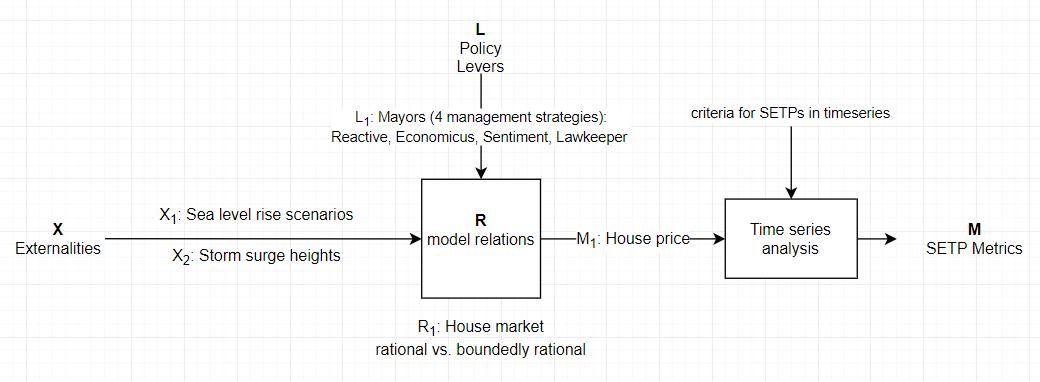

### Overview of model relations
<img src="Drawings/Mechanisms.dio.png" style="width: 600px" />

### Sea level rise scenarios
<img src="Visualisations/New_waterlevel_scenarios_till2300.png" style="width: 1000px" />

<br>
<br>

# ----------------------------------------------------------

# Illustration of one model run

# ----------------------------------------------------------
<br >
<br>

In [1]:
from classes import *
import copy
from collections import OrderedDict
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
#import ipywidgets as widgets
import pickle

import tqdm

from pdb import set_trace

from models import Rotty
from mayors import *
#global pars (for the development of Trust) Will be removed 
k = 0.2 
T_eq = 70

from run_model import run_model01

### Load and select Externalities (SLR scenarios, storm surge levels)

In [2]:
transient = "2"
selected_scens = ['01','03','05','09']

# Load all SLR_Scenario
allSLR_Scenario = SLR_Scenario_from_pickles(os.path.join("SLR_projections","Transients"))

# Load all SurgeHeight (Realisations of extreme value distribution)
for filename in os.listdir("SurgeHeight"):
    if filename.endswith(".csv"):
        obj = SurgeHeight(filename.split('.')[0]) #Init object with name derived from filename
        obj.from_csv(os.path.join('SurgeHeight',filename)) #Fill the object with data from the csv file

# Create SurgeLevels by summing combinations of SLR_Scenario and SurgeHeights
for SLR_Scenario in allSLR_Scenario:
    for SurgeHeight in allSurgeHeight:
        combine_SurgeLevel(SLR_Scenario,SurgeHeight)

# Make a manual preselection of scenarios to simplify plots

selection = [x for x in allSurgeLevel if x.name.split("__")[1] == transient] #only run experiments for one of the transients
selection =  [x for x in selection if x.name.split('__')[0].split('_')[1] in selected_scens]
selection

[Scenario_01__2, Scenario_03__2, Scenario_05__2, Scenario_09__2]

### Load policy lever (Mayors)

In [3]:
allMayors = [Reactive(),Economicus(),Sentiment(),Lawkeeper()]

### Run model for one Mayor over the selected scenarios

In [4]:
selected_mayor = Economicus()
mayor_experiments = []
for SurgeLevel in selection:
    experiment = run_model01(Rotty,SurgeLevel,selected_mayor,do_print=True)
    mayor_experiments.append(experiment)
print('experiments finished')

Finished experiment Rotty_Scenario_01__2_H. Economicus 2020/10/08, 11:36:40
Finished experiment Rotty_Scenario_03__2_H. Economicus 2020/10/08, 11:36:41
Finished experiment Rotty_Scenario_05__2_H. Economicus 2020/10/08, 11:36:41
Finished experiment Rotty_Scenario_09__2_H. Economicus 2020/10/08, 11:36:41
experiments finished


### And plot the results

Plot Marjolijn figuur 3. \
Tijdserie met twee pieken achter elkaar \
Tijdserie met extreem, voor in de eeuw, aan het eind van de eeuw. \
Reeks van 10,000 jaar maken, en daar stukjes uitknippen van 200 jaar. \

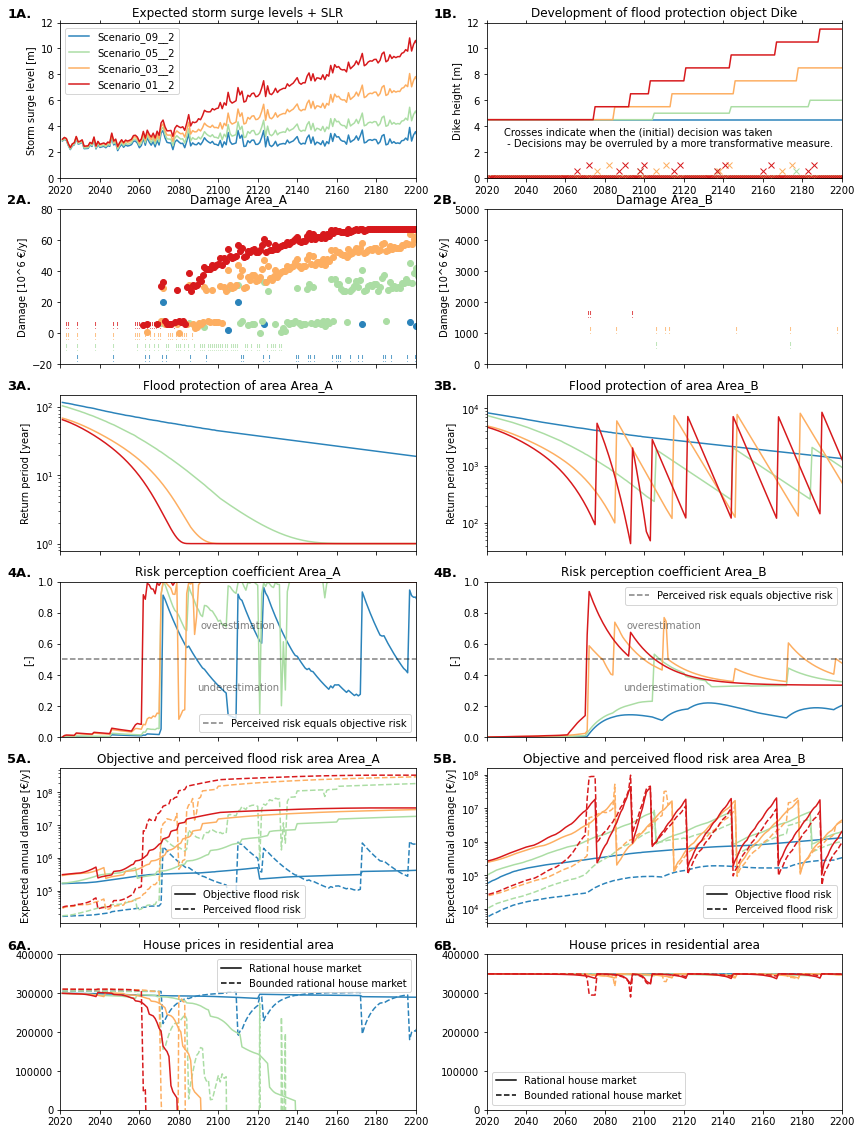

In [5]:
p1 = ['#e66101','#fdb863','#b2abd2','#5e3c99'] #palette
p2 = ['#d7191c','#fdae61','#abd9e9','#2c7bb6']
p3 = ['#d7191c','#fdae61','#abdda4','#2b83ba']
p = p3
p.reverse()

nrows=6
ncols=2

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,sharey=False,sharex=True,figsize=(14,20))

labels = []

xlim = (2020,2200)

for j,experiment in enumerate(reversed(mayor_experiments)):
    
    Model = experiment.Model
    SurgeLevel = experiment.SurgeLevel
    Mayor = experiment.Mayor
    
    time = SurgeLevel.years
    
    axes[0,0].plot(time,SurgeLevel.surgelevel,color=p[j])

    labels.append(SurgeLevel.name)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    #axes[0,0].set_xlabel('Time [year]')
    axes[0,0].set_ylabel('Storm surge level [m]')
    axes[0,0].set_ylim(0,12)
    axes[0,1].set_ylim(0,12)
    axes[0,1].set_ylabel('Dike height [m]')
    
    axes[0,0].set_xlim(xlim[0],xlim[1])
    
    axes[0,1].plot(time,Model.allFloodProtection[1].measure_history,'x',color=p[j]) #PLOT THE HISTORY OF THE MEASURES

    for i, Area in enumerate(Model.allResidentialArea):
        axes[0,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
       
           
        #plot damage
        axes[1,i].set_title('Damage {}'.format(Area.name))
        axes[1,i].plot(time,[x*10**(-6) for x in Model.allResidentialArea[i].flood_damage],'o',color=p[j])
        axes[1,i].set_ylabel('Damage [10^6 \u20ac/y]')
        #axes[1,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    
        axes[2,i].set_title('Flood protection of area {}'.format(Model.allResidentialArea[i].name))
        axes[2,i].plot(time,Model.allResidentialArea[i].protection_level_rp,'-',color=p[j])
        axes[2,i].set_yscale("log")
        axes[2,i].set_ylabel('Return period [year]')
        #axes[2,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    
        axes[3,i].set_title('Risk perception coefficient {}'.format(Model.allResidentialArea[i].name))
        axes[3,i].plot(time,Model.allResidentialArea[i].risk_perception,'-',color=p[j])
        axes[3,i].set_ylabel('[-]')
        axes[3,i].set_ylim(0,1)

        #axes[3,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        
        axes[4,i].set_title('Objective and perceived flood risk area {}'.format(Model.allResidentialArea[i].name))
        unit_corr = [x * 10**6 for x in Model.allResidentialArea[i].risk]
        axes[4,i].plot(time,unit_corr,'-',color=p[j])
        axes[4,i].set_yscale("log")
        axes[4,i].set_ylabel('Expected annual damage [\u20ac/y]')
        #axes[4,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        #Manually add legend patches
        custom_lines = [Line2D([0], [0], color='black',label='Objective flood risk',linestyle='-'),
                        Line2D([0], [0], color='black',label='Perceived flood risk',linestyle='--')]
        axes[4,i].legend(handles=custom_lines)
        
        unit_corr2 = [x * 10**6 for x in Model.allResidentialArea[i].risk_perceived]
        axes[4,i].plot(time,unit_corr2,'--',color=p[j])
        
        axes[5,i].set_title('House prices in residential area')
        axes[5,i].plot(time,Area.house_price_t_objective,color=p[j])
        custom_lines = [Line2D([0], [0], color='black',label='Rational house market',linestyle='-'),
                        Line2D([0], [0], color='black',label='Bounded rational house market',linestyle='--')]
        axes[5,i].legend(handles=custom_lines)
        axes[5,i].set_ylim(0,4e5)
        
        
        
        axes[5,i].plot(time,Area.house_price_t_subjective,'--',color=p[j])
        
        #axes[6,i].set_title('Development of trust in {} [DEPRECIATED]'.format(Area.name))
        #axes[6,i].plot(time,Model.allResidentialArea[i].trust_t,color=p[j])
        #axes[6,i].set_ylim(0,100)
    
    axes[0,1].plot(time,Model.allFloodProtection[1].protection_level,color=p[j])
    axes[0,1].set_title('Development of flood protection object Dike')
    
       
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[1,0].set_ylim(-20,80)
    HP = Model.allResidentialArea[0]
    for i,year in enumerate(time[0:xlim[1]-xlim[0]]):
        text = HP.event_history[i]
        if text == "!":
            axes[1,0].text(year,-18 + 7 * j,text,color=p[j],fontsize=8)
            
    #PLOT THE WAKE-UP CALL SIGNALS
    axes[1,1].set_ylim(0,5000)
    CC = Model.allResidentialArea[1]
    for i,year in enumerate(time[0:xlim[1]-xlim[0]]):
        text = CC.event_history[i]
        if text == "!":
            axes[1,1].text(year,0 + 500 * j,text,color=p[j],fontsize=8)

axes[0,0].legend(labels)

axes[0,1].text(0.05,0.2,"Crosses indicate when the (initial) decision was taken \n - Decisions may be overruled by a more transformative measure.",transform=axes[0,1].transAxes)


#PRINT THE THRESHOLD PROTECTION LEVELS FOR THE LAWKEEPER MAYOR
if Mayor.get_name() == 'Lawkeeper':
    axes[2,1].plot(time,[Mayor.threshold_small]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[2,1].plot(time,[Mayor.threshold_large]*len(time),color='black',linestyle='--',alpha=0.5)
    axes[2,1].text(2030,Mayor.threshold_small - 4000,'Threshold small measure',color='black',alpha=1)
    axes[2,1].text(2030,Mayor.threshold_large - 800,'Threshold large measure',color='black',alpha=1)
    
for j in [0,1]:
    alpha = 0.5
    color = 'black'
    axes[3,j].plot(time,[0.5]*len(time),color=color,linestyle='--',alpha = alpha)    
    #Manually add legend patches
    custom_line = [Line2D([0], [0], color=color, alpha=alpha,label='Perceived risk equals objective risk',linestyle='--')]
    axes[3,j].legend(handles=custom_line)
    axes[3,j].text(0.5,0.3,'underestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')
    axes[3,j].text(0.5,0.7,'overestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')


for nr in range(0,nrows):
    for l,letter in enumerate(('A','B')):
        axes[nr,l].text(-0.15, 1.1, "{}{}.".format(nr+1,letter), transform=axes[nr,l].transAxes,
                       fontsize=13, fontweight='bold', va='top')
    
#################################################################    
#################### SAVE THE EXPERIMENT ########################
#################################################################


filename = experiment.Mayor.get_name() + "_trans_" + experiment.SurgeLevel.name.split("__")[1]

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
foldername = date
target = os.path.join('Visualisations',foldername)
if not os.path.exists(target):
    os.mkdir(target)
else:
    print("Target folder {} already exists".format(target))
    
#fig.savefig(os.path.join(target,filename + "_new.png"),bbox_inches='tight',dpi=150)

<br>
<br>

# ----------------------------------------------------------

# Now, let's use the EMA-workbench

# ----------------------------------------------------------

<br>
<br>

We import a large set of experiments that were run with the EMA-Workbench on 6-10-2020.<br>
These include an assessment of the output time series on criterion 1: rapid change, to determine if SETPs happened. <br>
<b>An experiment has a tipping point if criterion 1 is met at least once before 2020.</b> <br>
<i>So that is, a change of the houseprice of more than 15% (compared to the initial house price in 2020) in one year.</i>

In [6]:
from ema_workbench import load_results

foldername = "temp"
subfolder = "experiments"
target = os.path.join(foldername,subfolder)

experiments, outcomes = load_results(os.path.join(target,"2020_10_6_EMA_experiments.tar.gz"))

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


<br>
<br>
<br>

## Feature scoring
Let's start with feature scoring, which is a sort of sensitivity analysis of the input factors (X,L,R) on the outcomes of the experiment. <br>
Only this time, we include some extra (bonus) output indicators, besides just the occurence of tipping points. Thesere are:

HP_hp_2200_obj : de huizenprijs in de Heijplaat, volgens een rationele huizenmarkt, in het jaar 2200

HP_hp_2200_sub : de huizenprijs in de Heijplaat, volgens een boundedly rational housing market, in het jaar 2200

CC__           : idem voor het stadscentrum

CC__           : idem voor het stadscentrum

HP_first_SETP  : Heijplaat: het jaartal waarin de eerste SETP plaatsvindt (nu alleen op basis van criterium 'rapid change')

CC_first_SETP  : City Centre: idem

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


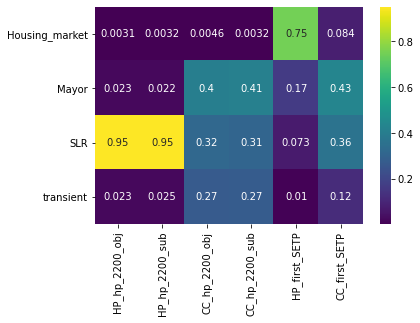

In [7]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns

x = experiments.copy().drop(['policy','model'],axis=1)
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

What can we learn from this? (col 1-4)
 - For the survival (~house price) of the Heijplaat, the sea level rise scenario explains everything (independent of which housing market)
 - For the city centre, it is first the Mayor (0.47), then SLR and Transient
 
For the timing of the SETP: (col 5-6)
 - In the Heijplaat the assumptions about the Housing market determines by far the most, the Mayor is a little bit. (Since there is one Mayor who can implement some flood-proofing)
 - In the city centre, many factors play a role. But is is mainly the Mayor (0.48), then the SLR scenario (0.31), then the choice for the housing market (0.12)

<br />
<br />
<br />

## Dimensional stacking 
This is a more visual approach to scenario discovery, indicating which combinations of input factors (X) explain outcome metrics of interest (M).

Dimensional stacking is described in Suzuki et al. (2015), but I currently don't have access to this. https://doi.org/10.2118/174774-MS
<br>
<br>
**This answers the question: what factors explain the occurence of SETPs in the City Centre before 2200?**
<br>
<br>

# KUn je nog proberen voor deze en volgende eeuw. 
# Kan nog steeds een invloed hebben op de timing

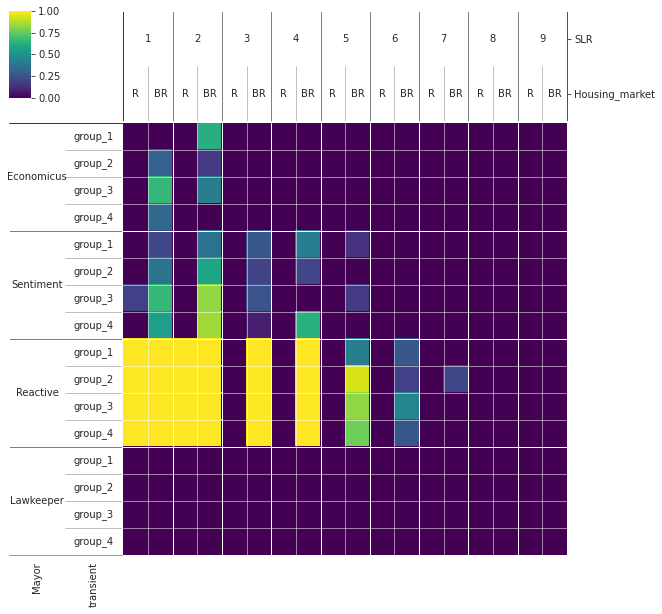

In [8]:
from ema_workbench.analysis import dimensional_stacking

experiments2 = experiments.copy()
map_house_market = {'rational' : 0, 
             'boundedly_rational' :1}
map_mayor = {'H. Economicus': 0,
             'Sentiment' : 1,
             'R. Active' : 2,
             'Lawkeeper' : 3}
experiments2['Housing_market'].replace(map_house_market,inplace=True)
experiments2['Mayor'].replace(map_mayor,inplace=True)
experiments2[['Housing_market', 'SLR', 'transient', 'Mayor', 'policy']].astype('float')

x = experiments2.drop('policy',axis=1)
y = outcomes['CC_first_SETP'] <2200
#y = outcomes['CC_first_SETP'] 

fig = dimensional_stacking.create_pivot_plot(x,y, nr_levels=2, nbins=4,categories=True)
#Get control over some labels
fig._axstack._elements[1][1][1].texts[0]._text = 'Economicus'
for i in range(1,5):
    fig._axstack._elements[1][1][1].texts[i]._text = 'group_{}'.format(i)
fig._axstack._elements[1][1][1].texts[5]._text = 'Sentiment'
j = 1
for i in range(6,10):
    fig._axstack._elements[1][1][1].texts[i]._text = 'group_{}'.format(j)
    j += 1
fig._axstack._elements[1][1][1].texts[10]._text = 'Reactive'
j = 1
for i in range(11,15):
    fig._axstack._elements[1][1][1].texts[i]._text = 'group_{}'.format(j)
    j += 1
fig._axstack._elements[1][1][1].texts[15]._text = 'Lawkeeper'
j = 1
for i in range(16,20):
    fig._axstack._elements[1][1][1].texts[i]._text = 'group_{}'.format(j)
    j += 1
    
#x-labels:
for i, text in enumerate(fig._axstack._elements[2][1][1].texts):
    if i%3 == 1:
        text._text = 'R'
    elif i%3 == 2:
        text._text = 'BR'
    #print(i,i//3,i%3,text._text)

What can we learn from the above? (note that each grid cell corresponds to 5 transient storm surge series)

Under Mayor *Reactive*, the concentration of SETPs is the highest. Under SLR scenario 1 and 2 they happen in both type of housing market. From SLR scenario 3 to 7 they only happen in a boundedly rational housing market. 

Under Mayor *Sentiment*, tipping points may still occur in a boundedly rational housing market, mainly under SLR scenario 1-4. Here, the transient scenario also starts to play a mayor role.

Under Mayor *Economicus*, there stil is a small likelihood of tipping points in a boundedly rational housing market, combined with the most extreme sea level rise scenario.

Even in the most extreme SLR scenario 1, tipping points can be still be avoided under mayor *Lawkeeper*

## 'Clustering' 
We know examine in a bit more detail which transient storm surge levels cause tipping points and which not, under furtherly equal situation.

Or to put it differently: what is happening in this box? Why do the 4x5 = 20 transients scenarios behave in different ways?

<img src="Visualisations/Dimensional_stacking_crit_1_box1.png" style="width: 600px" />
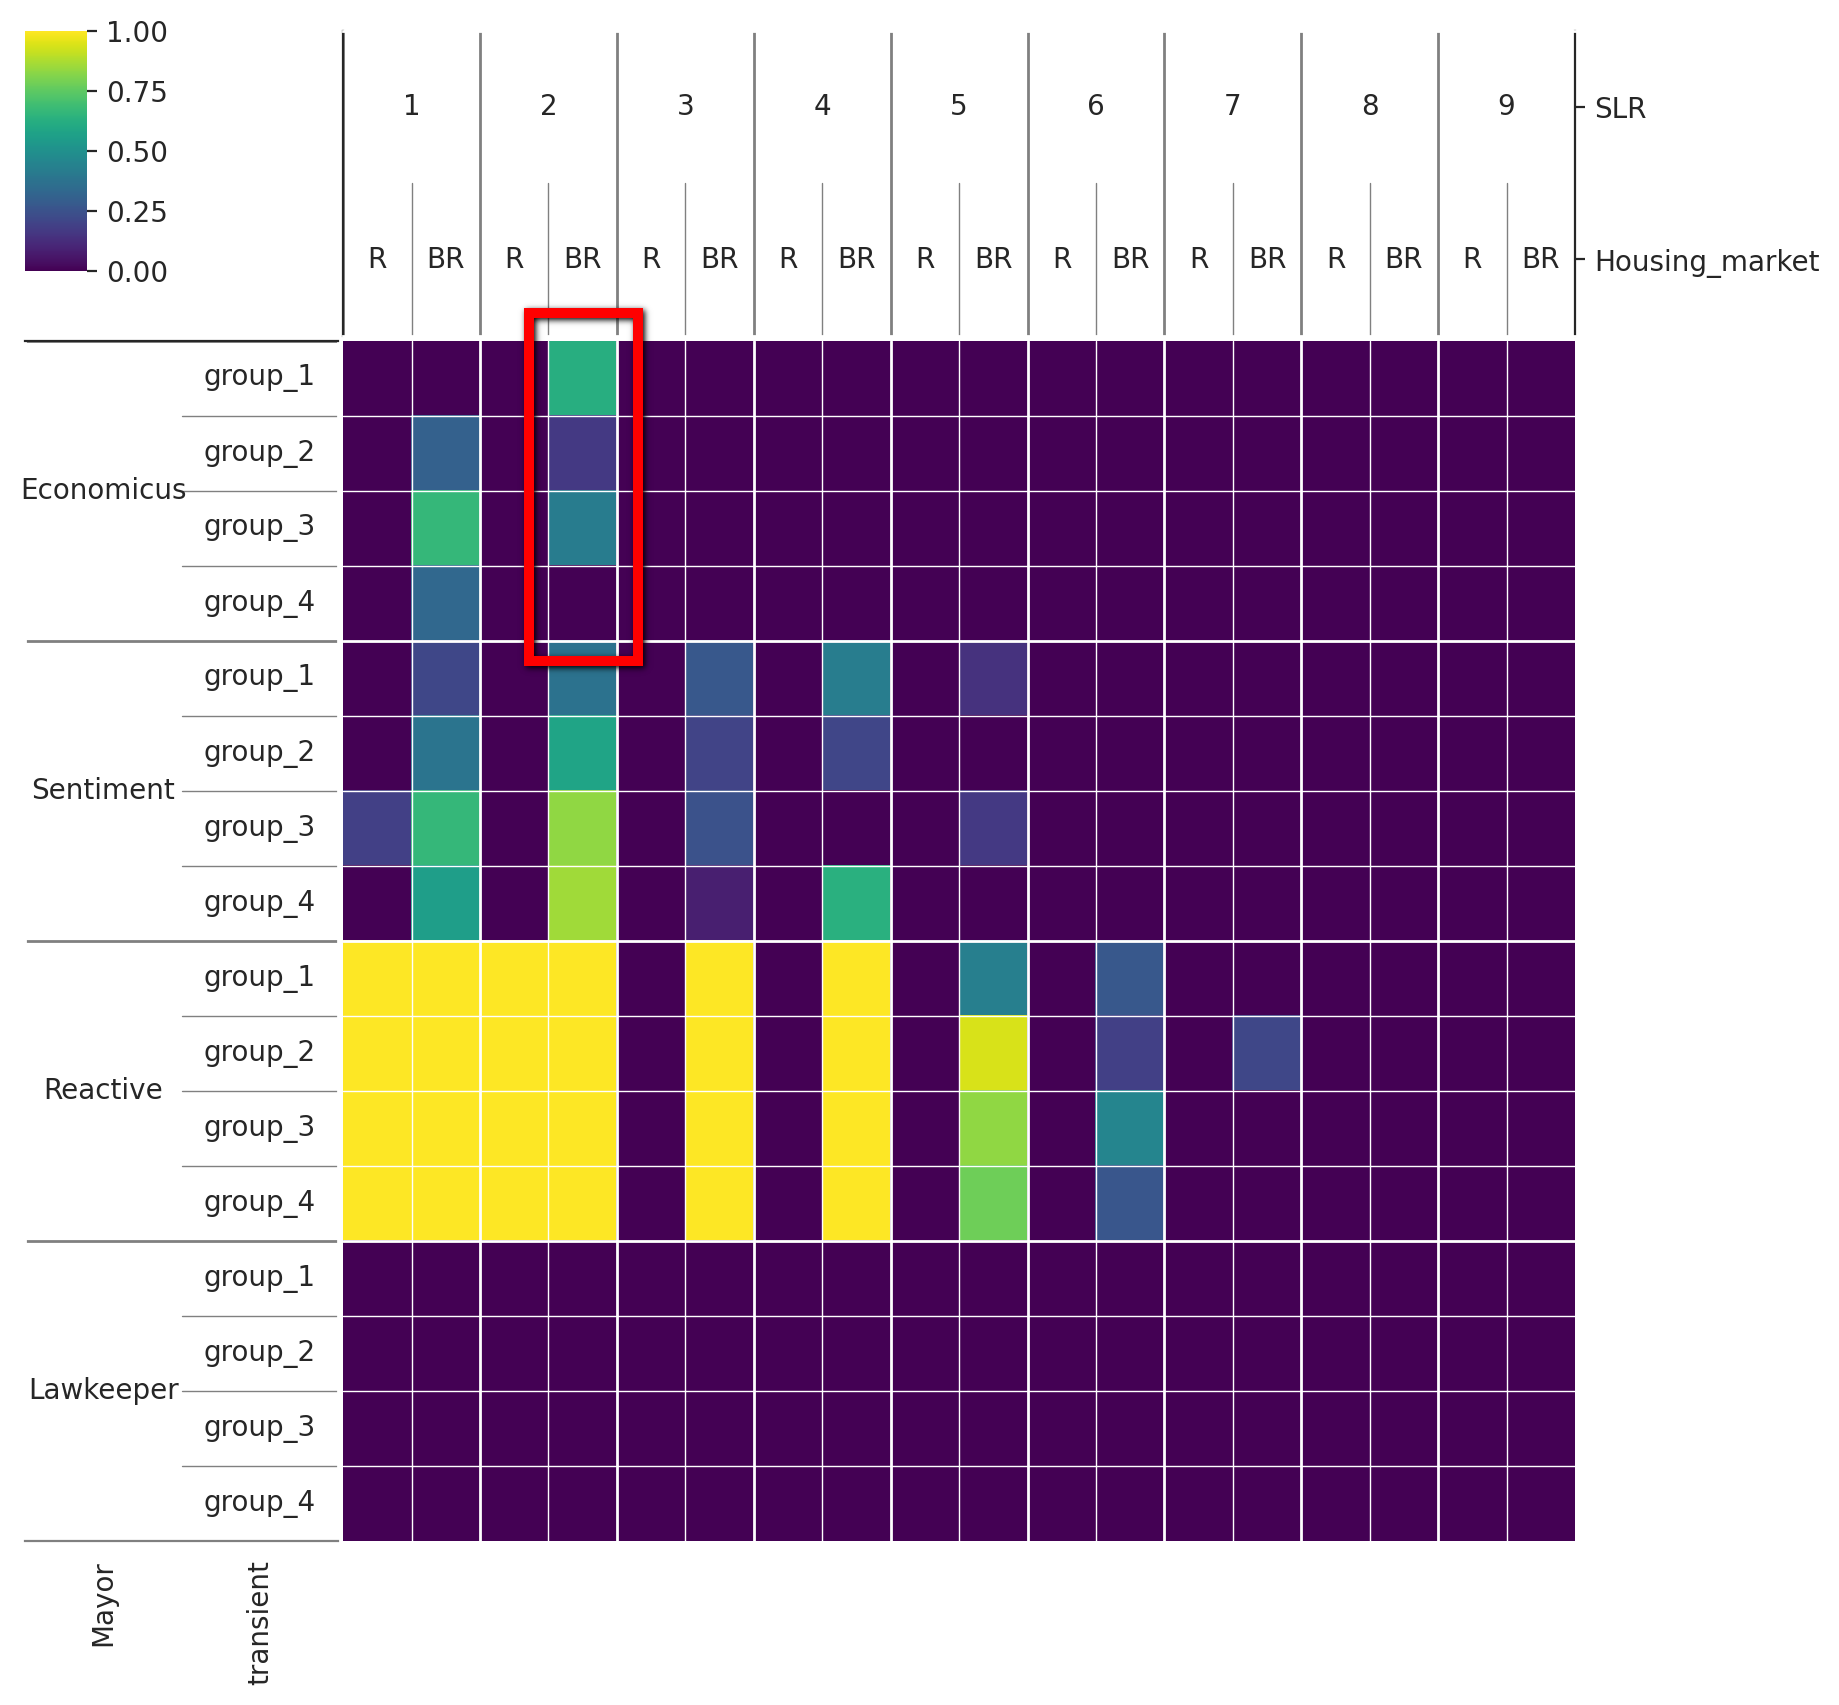

All these are experiments with:<br>
 X1: SLR = Scenario 2<br>
 L1: Mayor = Economicus<br>
 R1: Housing market = Boundedly rational

The only difference between them is the storm surge height series (X2)

So let's investigate these specific 20 cases.

In [9]:
selection =  [x for x in allSurgeLevel if x.name.split('__')[0].split('_')[1] in ['02']]
cluster_experiments = []
for SurgeLevel in selection:
    experiment = run_model01(Rotty,SurgeLevel,Economicus(),do_print=False)
    cluster_experiments.append(experiment)
print('experiments finished')

experiments finished


And also do the SETP-analysis with the help of criterion 1

In [10]:
window = 4 #The size of the rolling window
margin = 2 # The margin around the TP

c1 = 0.15*350_000 #TODO: make different per RA (300,000 and 350,000)

for experiment in cluster_experiments:
    experiment.create_Metrics()

    for M in experiment.allMetrics:
        M.create_statistics() #Create summary statistics for the metric(t)
        M.select_candidates(c1=c1,window=window,margin=margin) #Evaluate the three tipping point criteria
        M.first_SETP = M.candidates['rapid change'].first_valid_index() #The first year in which a rapid change is found

    experiment.CC_first_SETP = experiment.allMetrics[3].first_SETP
    #print(experiment.name,'-----------',experiment.CC_first_SETP)

D:\Python\Urban-SETP\classes.py:949: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a
D:\Python\Urban-SETP\classes.py:949: RuntimeWarning: invalid value encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


And plot the results in a summerized form:

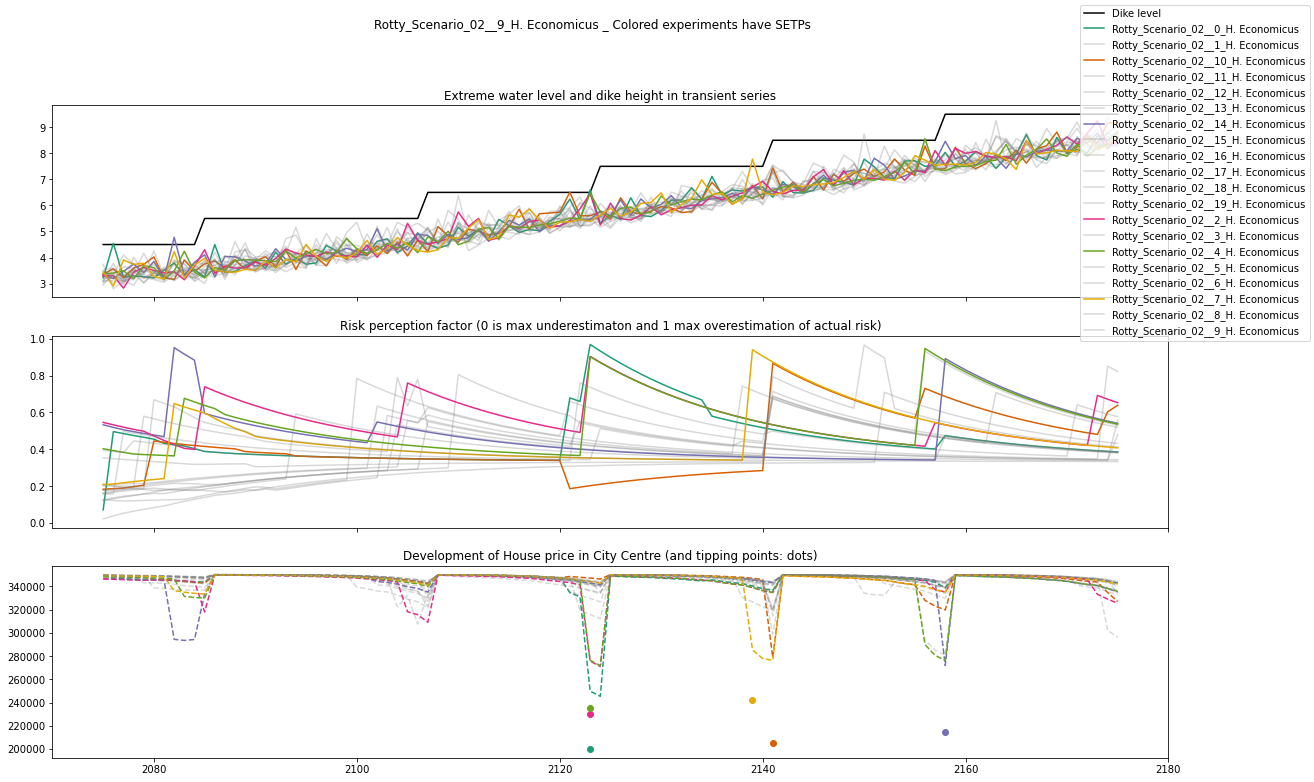

In [11]:
fig, axes = plt.subplots(3,1,figsize=(20,12),sharex=True)

legend = []

p = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'] #6 color palette

cluster_experiments[0].to_df().loc[2075:2175]['Dike_protection_level'].plot(ax=axes[0],color='black')
legend.append('Dike level')

j = 0
for i,experiment in enumerate(cluster_experiments):
    df = experiment.to_df().loc[2075:2175]
    legend.append(experiment.name)
    if experiment.CC_first_SETP is not None:
        sel_color = p[j]
        alpha=1
        j += 1
        axes[2].plot(experiment.CC_first_SETP,200_000+2500*i,'o',color=sel_color)
    else:
        sel_color = 'grey'
        alpha=0.3
    df['surgelevel'].plot(ax=axes[0],color=sel_color,alpha=alpha)
    df['Area_B_risk_perception'].plot(ax=axes[1],color=sel_color,alpha=alpha)
    df['Area_B_house_price_t_subjective'].plot(ax=axes[2],color=sel_color,linestyle='--',alpha=alpha)
    
axes[0].set_title('Extreme water level and dike height in transient series')
axes[1].set_title('Risk perception factor (0 is max underestimaton and 1 max overestimation of actual risk)')
axes[2].set_title('Development of House price in City Centre (and tipping points: dots)')

fig.suptitle('{} _ Colored experiments have SETPs'.format(experiment.name))

fig.legend(labels=legend)

filename = "box_1_clustered"
fig.savefig(os.path.join(target,filename + ".png"),bbox_inches='tight',dpi=150)

In the above picture, the six storm surge series that cause an SETP before 2200 are identified. What can we learn from this?

An interesting feature of Mayor Economicus is that his behaviour is **independent of the storm surge height series**. Economicus only anticipates on the rational flood risk in the city. Therefore, the dike is similarly heightened in all storm surge height series.

So what explains that it sometimes (in 6 of 20 scenarios) goes wrong? It is typically is just bad luck during the implementation time of the measures: a large flood strikes just before the dike raising has become functional. In this extreme sea level rise scenario, the mayor should have taken action earlier.

Hypotheses: longer lead time -> meer. Shorter lead time -> less. \
Decision point to invest is a bit late.

I expect that if we sample the storm surge height series more thoroughly with more experiments, we could also have tipping points earlier on (e.g. 21th century) or in more moderate scenarios (maybe scenario 3). 

BTW: the CBA that the mayor made clearly did not well enough anticipate this degree of sea level rise, because several floods happen!

*The identified examples are maybe not 'real' SETPs. There is a temporal drop in house price, but this quickly recovers to the original state*

## Clustering for another box

<img src='Visualisations/2020_10_7/Dimensional_stacking_crit_1_box2.png'  style="width: 600px" />

The box shows that we find 1 interesting time series in the box:
Mayor = Sentiment
Housing market = Rational
SLR_scenario = the most extreme one

In [12]:
selection =  [x for x in allSurgeLevel if x.name.split('__')[0].split('_')[1] in ['01']]
cluster_experiments = []
for SurgeLevel in selection:
    experiment = run_model01(Rotty,SurgeLevel,Sentiment(),do_print=False)
    
    HP = experiment.Model.allResidentialArea[0]
    CC = experiment.Model.allResidentialArea[1]
    
    ### CORRECT NEGATIVE HOUSE PRICES#
    #Return the timeseries of the house price.
    HP.house_price_t_objective = [x  if x > 0 else 0 for x in HP.house_price_t_objective] #set all values <0 to 0
    HP.house_price_t_subjective = [x  if x > 0 else 0 for x in HP.house_price_t_subjective]
    
    CC.house_price_t_objective = [x  if x > 0 else 0 for x in CC.house_price_t_objective] #set all values <0 to 0
    CC.house_price_t_subjective = [x  if x > 0 else 0 for x in CC.house_price_t_subjective]
    
    
    cluster_experiments.append(experiment)

    
    
    
window = 4 #The size of the rolling window
margin = 2 # The margin around the TP

c1 = 0.15*350_000 #TODO: make different per RA (300,000 and 350,000)

for experiment in cluster_experiments:
    experiment.create_Metrics()

    for M in experiment.allMetrics:
        M.create_statistics() #Create summary statistics for the metric(t)
        M.select_candidates(c1=c1,window=window,margin=margin) #Evaluate the three tipping point criteria
        M.first_SETP = M.candidates['rapid change'].first_valid_index() #The first year in which a rapid change is found

    #experiment.CC_first_SETP = experiment.allMetrics[2].first_SETP
    print(experiment.name,'-----------',experiment.allMetrics[2].first_SETP)

D:\Python\Urban-SETP\classes.py:949: RuntimeWarning: divide by zero encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a
D:\Python\Urban-SETP\classes.py:949: RuntimeWarning: invalid value encountered in double_scalars
  perc = 100*(avg_a-avg_b)/avg_a


Rotty_Scenario_01__0_Sentiment ----------- 2221
Rotty_Scenario_01__1_Sentiment ----------- 2221
Rotty_Scenario_01__10_Sentiment ----------- 2221
Rotty_Scenario_01__11_Sentiment ----------- 2098
Rotty_Scenario_01__12_Sentiment ----------- 2221
Rotty_Scenario_01__13_Sentiment ----------- 2221
Rotty_Scenario_01__14_Sentiment ----------- 2221
Rotty_Scenario_01__15_Sentiment ----------- 2221
Rotty_Scenario_01__16_Sentiment ----------- 2221
Rotty_Scenario_01__17_Sentiment ----------- 2221
Rotty_Scenario_01__18_Sentiment ----------- 2221
Rotty_Scenario_01__19_Sentiment ----------- 2221
Rotty_Scenario_01__2_Sentiment ----------- 2221
Rotty_Scenario_01__3_Sentiment ----------- 2221
Rotty_Scenario_01__4_Sentiment ----------- 2221
Rotty_Scenario_01__5_Sentiment ----------- 2221
Rotty_Scenario_01__6_Sentiment ----------- 2221
Rotty_Scenario_01__7_Sentiment ----------- 2221
Rotty_Scenario_01__8_Sentiment ----------- 2221
Rotty_Scenario_01__9_Sentiment ----------- 2221


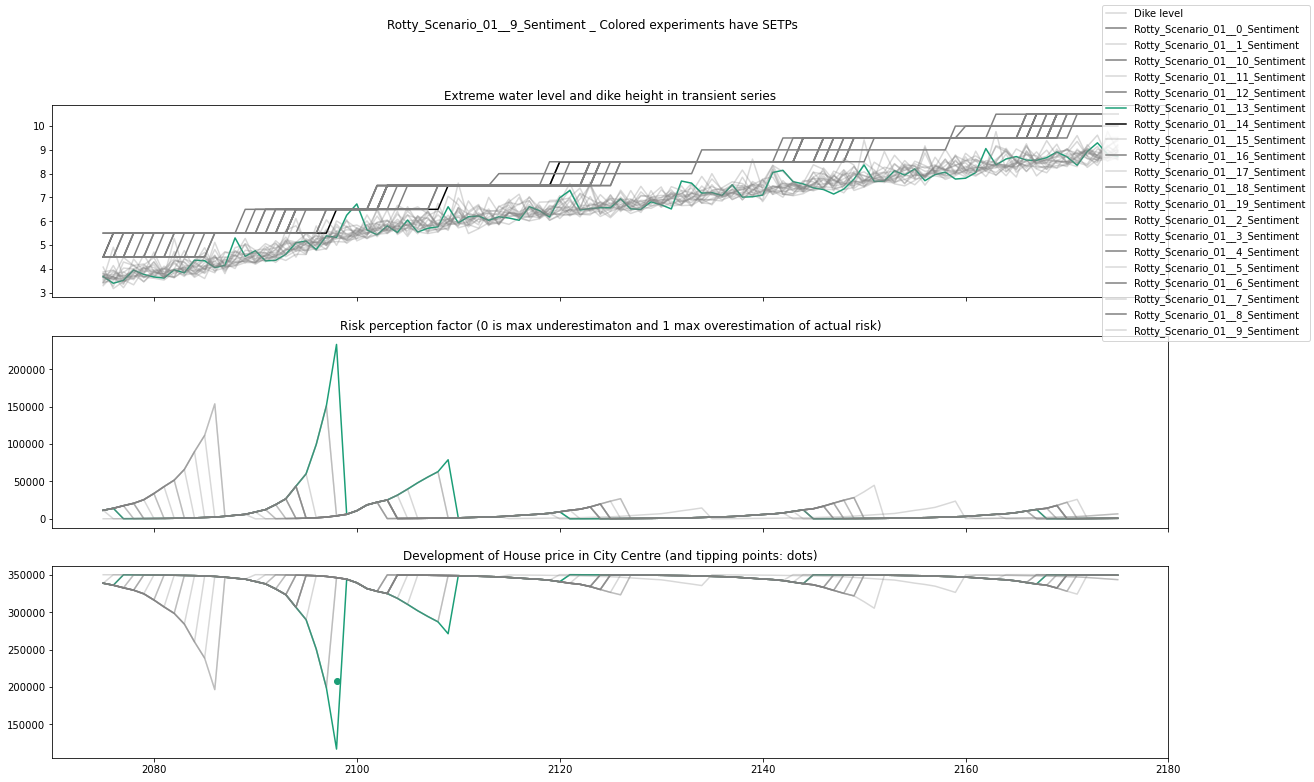

In [13]:
fig, axes = plt.subplots(3,1,figsize=(20,12),sharex=True)

legend = []

p = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'] #6 color palette
p = p * 4
#cluster_experiments[0].to_df().loc[2075:2175]['Dike_protection_level'].plot(ax=axes[0],color='black')
legend.append('Dike level')

j = 0
for i,experiment in enumerate(cluster_experiments):
    df = experiment.to_df().loc[2075:2175]
    legend.append(experiment.name)
    if experiment.allMetrics[2].first_SETP is not None and experiment.allMetrics[2].first_SETP < 2200:
        sel_color = p[j]
        alpha=1
        dike_color = 'black'
        j += 1
        axes[2].plot(experiment.allMetrics[2].first_SETP,200_000+2500*i,'o',color=sel_color)
    else:
        sel_color = 'grey'
        alpha=0.3
        dike_color = 'grey'
    df['surgelevel'].plot(ax=axes[0],color=sel_color,alpha=alpha)
    df['Area_B_risk_household_discounted'].plot(ax=axes[1],color=sel_color,alpha=alpha)
    df['Area_B_house_price_t_objective'].plot(ax=axes[2],color=sel_color,linestyle='-',alpha=alpha)
    df['Dike_protection_level'].plot(ax=axes[0],color=dike_color)
    
axes[0].set_title('Extreme water level and dike height in transient series')
axes[1].set_title('Risk perception factor (0 is max underestimaton and 1 max overestimation of actual risk)')
axes[2].set_title('Development of House price in City Centre (and tipping points: dots)')

fig.suptitle('{} _ Colored experiments have SETPs'.format(experiment.name))

fig.legend(labels=legend)

filename = "box_2_clustered"
#fig.savefig(os.path.join(target,filename + ".png"),bbox_inches='tight',dpi=150)

Indeed, there is only one time series for which the script identified an SETP. This time series 13, does not occur in the 6 time series we examined in the previous cluster! 

<br><br><br><br>

## Scenario Discovery 

From the feature scoring, we can formulate the hypothesis: the transient storm scenarios cannot be clustered on the basis of merely their shape. What is possible, however, is to make groups if the mayor and SLR scenario are already set.

In [14]:
from ema_workbench.analysis import prim
x = experiments.copy().drop('policy',axis=1)
y = outcomes['CC_first_SETP'] < 2200
prim_alg = prim.Prim(x,y,threshold=0.8)
box1 = prim_alg.find_box()

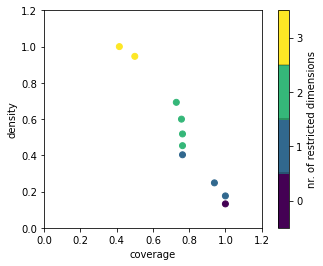

In [15]:
#%matplotlib widget
%matplotlib inline
fig = box1.show_tradeoff()

Zelfs in het meest kleine boxje (helemaal linksboven), wordt er **geen** beperking op de transients uitgevoerd.

In [16]:
box1.box_lims[9]

,Housing_market,SLR,transient,Mayor
0,{boundedly_rational},"{1, 2, 3, 4}",0.0,{R. Active}
1,{boundedly_rational},"{1, 2, 3, 4}",19.0,{R. Active}


<br /><br /><br /><br />

## Parallel Coordinate plot

This answers the question:<br />
<b>If we start reasoning from the transients, can we say anything about how it impacts the <u> likelihood and the timing </u> of SETPs?

In [180]:
from ema_workbench.analysis import parcoords

df = pd.DataFrame(outcomes)['CC_first_SETP']
ooi = df[df<2200] #outcomes of interest
eoi = experiments[df<2200] #experiments of interest
eoi = eoi.drop(['policy','model','scenario'],axis=1)
data = pd.merge(eoi,ooi,left_index=True,right_index=True)
data.head()

,Housing_market,SLR,transient,Mayor,CC_first_SETP
0,boundedly_rational,1,17.0,R. Active,2082
3,boundedly_rational,2,13.0,R. Active,2094
4,boundedly_rational,4,17.0,R. Active,2103
16,boundedly_rational,3,6.0,R. Active,2093
18,boundedly_rational,6,13.0,R. Active,2192


In [181]:
map_house_market = {'rational' : 0, 
             'boundedly_rational' :1}
map_mayor = {'H. Economicus': 0,
             'Sentiment' : 1,
             'R. Active' : 2,
             'Lawkeeper' : 3}
data['Housing_market'].replace(map_house_market,inplace=True)
data['Mayor'].replace(map_mayor,inplace=True)
data = data[['transient','Mayor','SLR','Housing_market','CC_first_SETP']].astype('int')
data.head()

,transient,Mayor,SLR,Housing_market,CC_first_SETP
0,17,2,1,1,2082
3,13,2,2,1,2094
4,17,2,4,1,2103
16,6,2,3,1,2093
18,13,2,6,1,2192


In [182]:
#limits = parcoords.get_limits(data_sel)
limits = pd.DataFrame({
    'transient' : [0,19],
    'Mayor' : [0,4],
    'SLR' : [0,9],
    'Housing_market' : [0,1],
    'CC_first_SETP' : [2050,2200]
})
limits

,transient,Mayor,SLR,Housing_market,CC_first_SETP
0,0,0,0,0,2050
1,19,4,9,1,2200


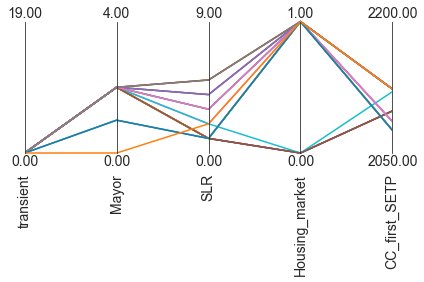

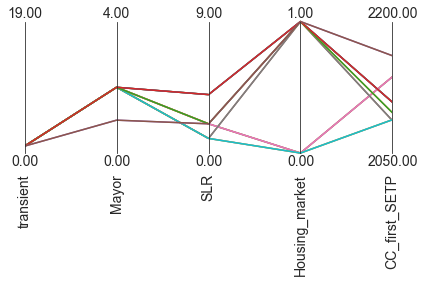

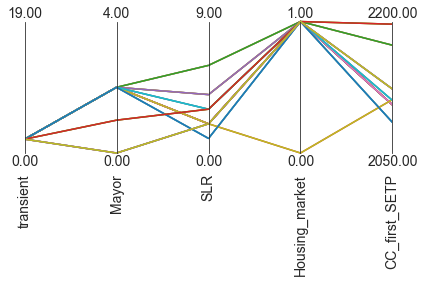

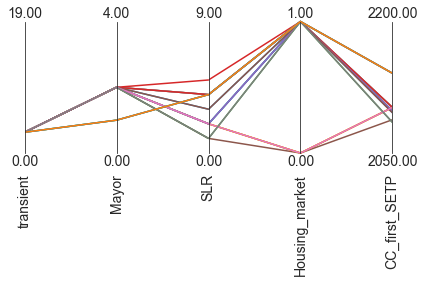

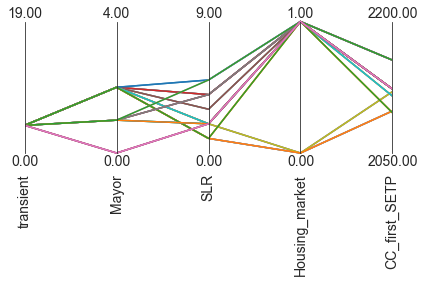

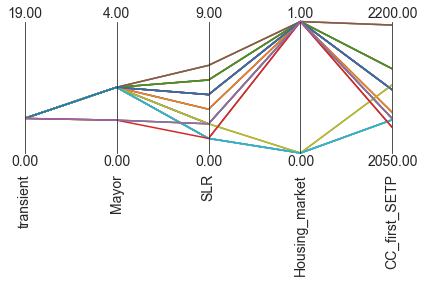

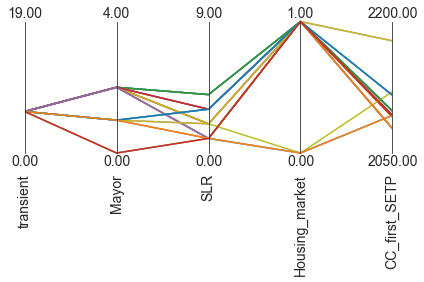

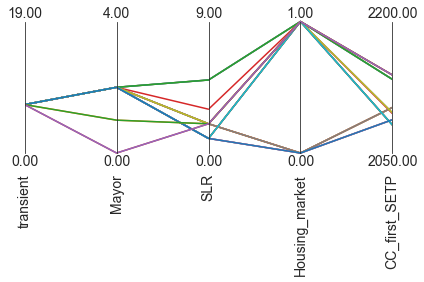

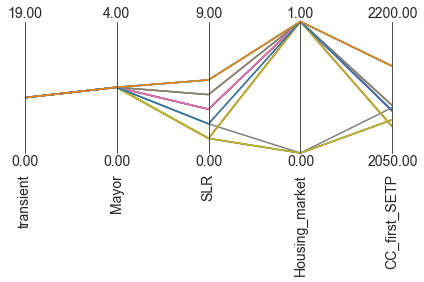

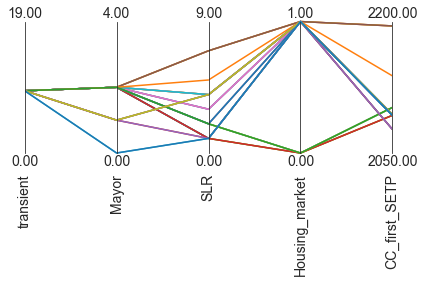

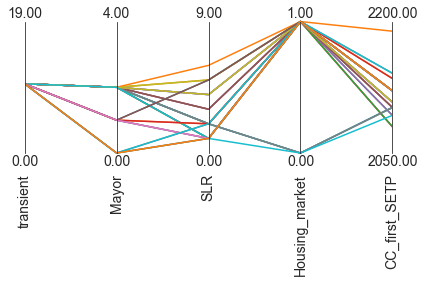

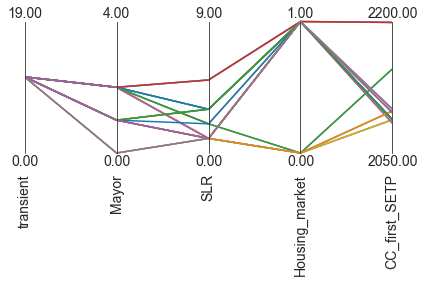

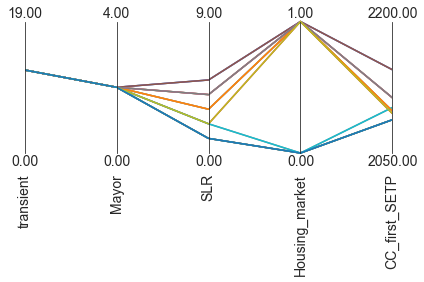

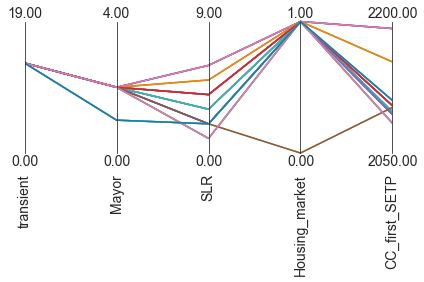

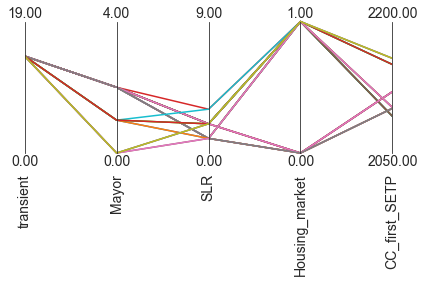

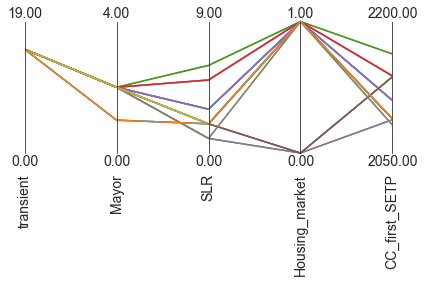

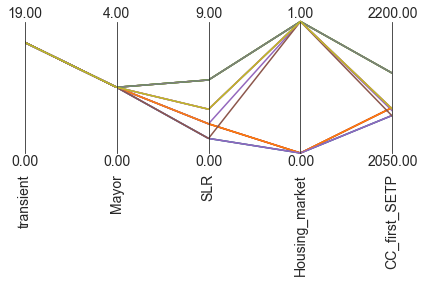

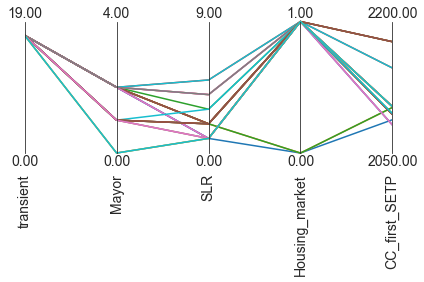

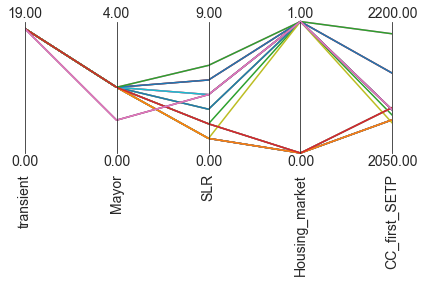

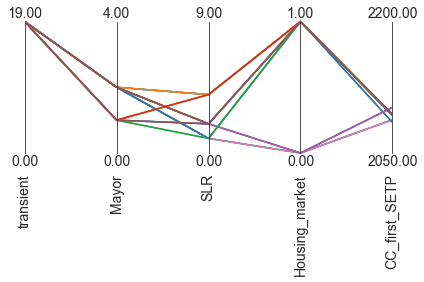

In [183]:
for i in range(0,20):
    data_sel = data[data['transient']==i]
    #limits = parcoords.get_limits(data_sel)
    paraxes = parcoords.ParallelAxes(limits )
    paraxes.plot(data_sel)

In [191]:
data.groupby('transient').count().sort_values(by='CC_first_SETP')

,Mayor,SLR,Housing_market,CC_first_SETP
transient,,,,
1,16,16,16,16
16,19,19,19,19
12,21,21,21,21
0,22,22,22,22
3,22,22,22,22
15,22,22,22,22
8,22,22,22,22
6,24,24,24,24
7,25,25,25,25


In [192]:
data.groupby('transient').mean().sort_values(by='CC_first_SETP')

,Mayor,SLR,Housing_market,CC_first_SETP
transient,,,,
19,1.615385,2.346154,0.769231,2093.230769
0,1.772727,2.363636,0.772727,2098.772727
6,1.541667,2.208333,0.833333,2102.250000
9,1.677419,2.903226,0.774194,2103.677419
12,2.000000,2.714286,0.619048,2104.809524
7,1.760000,2.160000,0.640000,2106.040000
8,2.000000,2.909091,0.818182,2106.772727
11,1.428571,2.000000,0.714286,2106.821429
18,1.888889,2.888889,0.592593,2106.925926


In [194]:
data.groupby('transient').median().sort_values(by='CC_first_SETP')

,Mayor,SLR,Housing_market,CC_first_SETP
transient,,,,
11,2.0,1.0,1.0,2092.0
6,2.0,2.0,1.0,2093.0
19,2.0,2.0,1.0,2093.5
9,2.0,2.0,1.0,2094.0
8,2.0,3.0,1.0,2098.0
12,2.0,3.0,1.0,2098.0
0,2.0,2.0,1.0,2098.0
18,2.0,3.0,1.0,2099.0
7,2.0,2.0,1.0,2102.0
